In [1]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, recall_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import sqlite3
import pandas as pd
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
conn = sqlite3.connect(r'C:\Users\spiri\codingbootcamp\Final-project-C4Y\data.db')
cursor = conn.cursor()
query = ('''WITH sum_balance as (
    select 
         client_id,
         SUM(balance) as sum_balance,
         currency
    from balances
    group by 1
)
Select inv_campaign_eval.client_id, inv_campaign_eval.poutcome, sum_balance.sum_balance, sum_balance.currency, client.job 
from inv_campaign_eval
left join sum_balance
on inv_campaign_eval.client_id = sum_balance.client_id
left join client
on inv_campaign_eval.client_id = client.client_id''')
df = pd.read_sql_query(query, conn)

df

,client_id,poutcome,sum_balance,currency,job
0,249789938,success,69407.851087,CZK,services
1,1504633819,failure,141462.420695,CZK,management
2,1952195738,success,75996.930142,CZK,services
3,989726384,success,81239.985906,CZK,retired
4,1971878545,failure,12326.158848,CZK,management
...,...,...,...,...,...
2294,1270855655,failure,87084.350979,CZK,admin.
2295,471724023,success,120782.311388,CZK,retired
2296,620088171,failure,23281.840134,CZK,admin.
2297,1518319265,success,2014.860158,CZK,management


In [3]:
df.nunique()

client_id      2299
poutcome          2
sum_balance    2299
currency          3
job              12
dtype: int64

In [4]:
rate = {'CZK': 1, 'USD': 23, 'EUR': 25}

df.mean_balance = df.apply(lambda row: row['sum_balance'] * rate[row['currency']], axis=1)

C:\Users\spiri\AppData\Local\Temp\ipykernel_20068\2392447873.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.mean_balance = df.apply(lambda row: row['sum_balance'] * rate[row['currency']], axis=1)


In [5]:

success=df[df.poutcome == 'success']
success.dtypes


client_id        int64
poutcome        object
sum_balance    float64
currency        object
job             object
dtype: object

In [6]:
bins = [ success.sum_balance.min() ,success.sum_balance.median(), success.sum_balance.quantile(0.9), 100000000000000]
labels = ['poor', 'middle','rich']

success['balance_group'] = pd.cut(success['sum_balance'], bins=bins, labels=labels, right=False)


C:\Users\spiri\AppData\Local\Temp\ipykernel_20068\2299885353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success['balance_group'] = pd.cut(success['sum_balance'], bins=bins, labels=labels, right=False)


In [7]:
success.job.fillna('unknown', inplace=True)
success.job.unique()

C:\Users\spiri\AppData\Local\Temp\ipykernel_20068\2280083887.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  success.job.fillna('unknown', inplace=True)
C:\Users\spiri\AppData\Local\Temp\ipykernel_20068\2280083887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success.job.fillna('unknown', inplace=True)


array(['services', 'retired', 'management', 'student', 'entrepreneur',
       'admin.', 'technician', 'blue-collar', 'unknown', 'unemployed',
       'housemaid', 'self-employed'], dtype=object)

In [8]:
success.job.fillna('unknown', inplace=True)
income_dict = {
    'services': 377580,  
    'retired' : 242520,
    'management': 960000,
    'student' : 226800,
    'entrepreneur': 483888,
    'admin.' : 600000,
    'technician': 649000,
    'blue-collar': 358953,
    'unknown': 515868,
    'unemployed': 226800,
    'housemaid': 0, 
    'self-employed': 515868,
}
success['anual_income'] = success['job'].map(income_dict)
success

C:\Users\spiri\AppData\Local\Temp\ipykernel_20068\713083907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success.job.fillna('unknown', inplace=True)
C:\Users\spiri\AppData\Local\Temp\ipykernel_20068\713083907.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success['anual_income'] = success['job'].map(income_dict)


,client_id,poutcome,sum_balance,currency,job,balance_group,anual_income
0,249789938,success,69407.851087,CZK,services,middle,377580
2,1952195738,success,75996.930142,CZK,services,middle,377580
3,989726384,success,81239.985906,CZK,retired,middle,242520
7,178705988,success,28013.981174,CZK,management,middle,960000
8,1744740913,success,46322.648302,CZK,student,middle,226800
...,...,...,...,...,...,...,...
2292,727430476,success,26508.331013,CZK,management,middle,960000
2293,1404318820,success,2017.648965,CZK,technician,poor,649000
2295,471724023,success,120782.311388,CZK,retired,middle,242520
2297,1518319265,success,2014.860158,CZK,management,poor,960000


Here we develop a function to predict yearly revenue by considering investment balances and projected growth factors.

In [9]:
mothly_investments_poor=0.05
mothly_investments_middle=0.1
mothly_investments_rich = 0.15
commision = 0.02
Churn_probability = 0.8
year = 10
income_increase = 1.1

def profit_count(df):
    profit = 0
    for x, i in df.iterrows():
        if i.sum_balance < 0:
            pass
        elif i.balance_group == 'poor':
            profit += i.anual_income*mothly_investments_poor*commision
        elif i.balance_group == 'middle':
            profit += i.anual_income*mothly_investments_middle*commision
        else:
            profit += i.anual_income*mothly_investments_rich*commision
    return profit

def profits_by_year(n,df):
    profits = []
    for i in range(n):
        if i == 0:
            profits.append(round(profit_count(df), 0))
        else:   
            next_term = profits[-1] + profit_count(df)*Churn_probability*income_increase**(i/2)  
            profits.append(round(next_term, 0))  
    return profits



In [10]:
decade_perspective=profits_by_year(year, success)
decade_perspective

[957592.0,
 1761057.0,
 2603738.0,
 3487549.0,
 4414498.0,
 5386690.0,
 6406334.0,
 7475746.0,
 8597354.0,
 9773707.0]

In [11]:
rf=profit_count(success)
rf

957591.9350000004

In [12]:
cursor = conn.cursor()
query1 = ('''
WITH sum_balance as (
    select 
         client_id,
         SUM(balance) as sum_balance,
         currency
    from balances
    group by 1
)
Select client.client_id, sum_balance.sum_balance, sum_balance.currency, client.job
FROM client
LEFT JOIN inv_campaign_eval ON client.client_id = inv_campaign_eval.client_id
left join sum_balance on client.client_id = sum_balance.client_id
WHERE inv_campaign_eval.client_id is null''')
df1 = pd.read_sql_query(query1, conn)

df1

df1.job.fillna('unknown', inplace=True)
income_dict = {
    'services': 377580,  
    'retired' : 242520,
    'management': 960000,
    'student' : 226800,
    'entrepreneur': 483888,
    'admin.' : 600000,
    'technician': 649000,
    'blue-collar': 358953,
    'unknown': 515868,
    'unemployed': 226800,
    'housemaid': 0, 
    'self-employed': 515868,
}
df1['anual_income'] = df1['job'].map(income_dict)
df1

C:\Users\spiri\AppData\Local\Temp\ipykernel_20068\2836243553.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1.job.fillna('unknown', inplace=True)


,client_id,sum_balance,currency,job,anual_income
0,1222646323,24974.613893,CZK,services,377580
1,451375919,31746.426883,CZK,admin.,600000
2,338972671,7747.824877,CZK,self-employed,515868
3,1472834688,49902.271760,CZK,blue-collar,358953
4,1068680340,25.275384,CZK,admin.,600000
...,...,...,...,...,...
8858,440873221,10061.883682,CZK,management,960000
8859,543198889,479.489539,CZK,blue-collar,358953
8860,458558558,664.370370,CZK,housemaid,0
8861,1426334329,82100.725243,CZK,technician,649000


In [13]:
clients_id = pd.read_csv(r'C:\Users\spiri\codingbootcamp\Final-project-C4Y\client_ids.csv')
clients_id_sample = clients_id.sample(frac=0.4)
clients_id_sample

,client_id
529,777124281
2127,1751652673
2884,100646594
1710,975467198
2630,965835277
...,...
1316,1640240870
2146,1606761042
2054,1635262538
2795,1335817823


In [14]:
joined = pd.merge(df1, clients_id_sample, on=['client_id','client_id'], how="inner", indicator=True)
joined.drop(columns=[ '_merge'], inplace=True)

joined['balance_group'] = pd.cut(joined['sum_balance'], bins=bins, labels=labels, right=False)
joined

,client_id,sum_balance,currency,job,anual_income,balance_group
0,422084751,66591.806986,CZK,technician,649000,middle
1,122279077,4558.078063,CZK,self-employed,515868,poor
2,1177854254,631809.104078,CZK,blue-collar,358953,rich
3,985873256,2027.172396,CZK,admin.,600000,poor
4,1035374127,45773.091660,CZK,unknown,515868,middle
...,...,...,...,...,...,...
1195,1903776674,5849.667864,CZK,management,960000,poor
1196,887694228,98326.210944,CZK,blue-collar,358953,middle
1197,1208330461,3974.061910,CZK,management,960000,poor
1198,1335817823,6226.079017,CZK,blue-collar,358953,poor


In [15]:
clients_id_result = pd.read_csv(r'C:\Users\spiri\codingbootcamp\Final-project-C4Y\client_ids_evaluated.csv')
clients_id_result_success = clients_id_result[clients_id_result['poutcome']==1]
clients_id_result_success

,client_id,poutcome
1,422084751,1
2,123316323,1
4,122279077,1
5,1177854254,1
6,985873256,1
...,...,...
2976,884109138,1
2981,503741083,1
2988,762150238,1
2994,1211152203,1


In [16]:
results = pd.merge(df1, clients_id_result_success, on=['client_id','client_id'], how="inner", indicator=True)
results.drop(columns=[ '_merge'], inplace=True)

results['balance_group'] = pd.cut(results['sum_balance'], bins=bins, labels=labels, right=False)
results

,client_id,sum_balance,currency,job,anual_income,poutcome,balance_group
0,422084751,66591.806986,CZK,technician,649000,1,middle
1,123316323,73867.791408,CZK,blue-collar,358953,1,middle
2,122279077,4558.078063,CZK,self-employed,515868,1,poor
3,1177854254,631809.104078,CZK,blue-collar,358953,1,rich
4,985873256,2027.172396,CZK,admin.,600000,1,poor
...,...,...,...,...,...,...,...
1353,1246438882,32045.310017,CZK,technician,649000,1,middle
1354,887694228,98326.210944,CZK,blue-collar,358953,1,middle
1355,1182886062,57546.827384,CZK,admin.,600000,1,middle
1356,1335817823,6226.079017,CZK,blue-collar,358953,1,poor


In [17]:
decade_perspective_prediction=profits_by_year(year, joined)

In [18]:
decade_perspective_evaluation=profits_by_year(year, results)

In [19]:
decade_perspective = [x / 1000000 for x in decade_perspective]
decade_perspective_prediction = [x / 1000000 for x in decade_perspective_prediction]
decade_perspective_evaluation = [x / 1000000 for x in decade_perspective_evaluation]

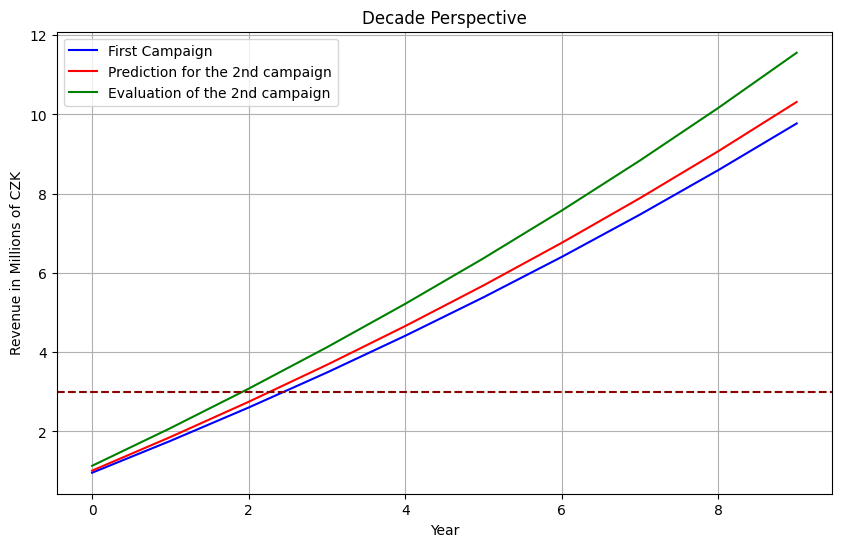

In [21]:
import matplotlib.pyplot as plt

input_dict = {
    'First Campaign':{
        'data': decade_perspective,
        'xaxis': range(year),
        'color': 'blue'
    },
    'Prediction for the 2nd campaign':{
        'data': decade_perspective_prediction,
        'xaxis': range(year),
        'color': 'red'
    },
    'Evaluation of the 2nd campaign':{
        'data': decade_perspective_evaluation,
        'xaxis': range(year),
        'color': 'green'
    }
}

def plot_line_graph(input_dict):
    plt.figure(figsize=(10, 6))
    
    for key, value in input_dict.items():
        data = value['data']
        xaxis = value['xaxis']
        color = value['color']
        
        plt.plot(xaxis, data, label=key, color=color)  
        
    plt.xlabel('Year')
    plt.ylabel('Revenue in Millions of CZK')
    plt.title('Decade Perspective')
    plt.legend()
    plt.axhline(y=3, color='darkred', linestyle='--')
    plt.grid(True)
    
    plt.show()

plot_line_graph(input_dict)